In [14]:
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [2]:
transforms_augment = tran.Compose([
    tran.ToTensor(mask_as_integer=True),
    tran.Resize((256, 256)),
    tran.RandomHorizontalFlip(),
    tran.RandomVerticalFlip(),
    tran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

transforms_val = tran.Compose([
    tran.ToTensor(mask_as_integer=True),
    tran.Resize((256, 256)),
    tran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [3]:
train = TrainDataset('../data/', transform=transforms_augment, with_background=True, as_id_mask=True)
#test = TestDataset('../data/', transform=transforms, with_background=True, as_id_mask=True)
val = ValDataset('../data/', transform=transforms_val, with_background=True, as_id_mask=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


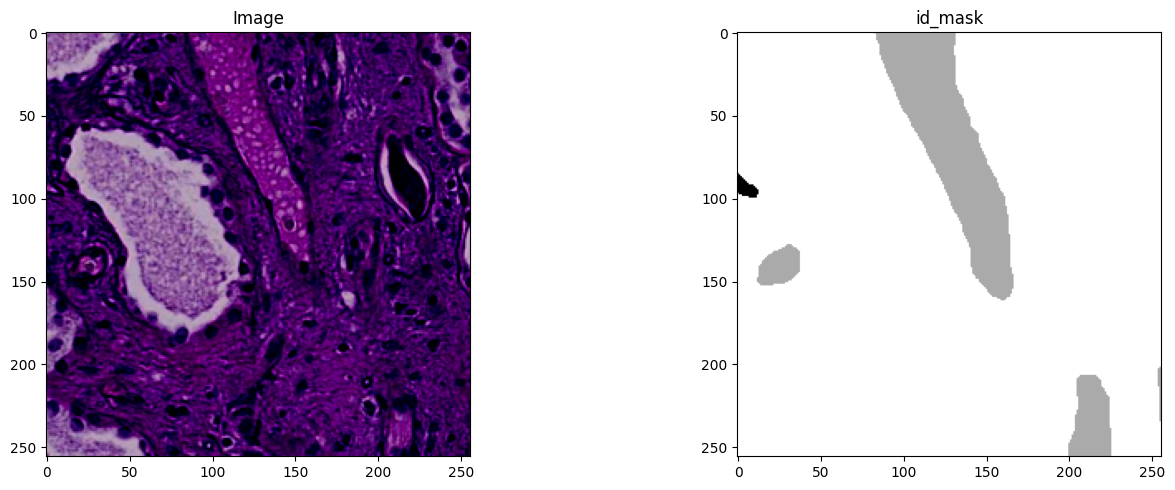

In [8]:
train.plot_example(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


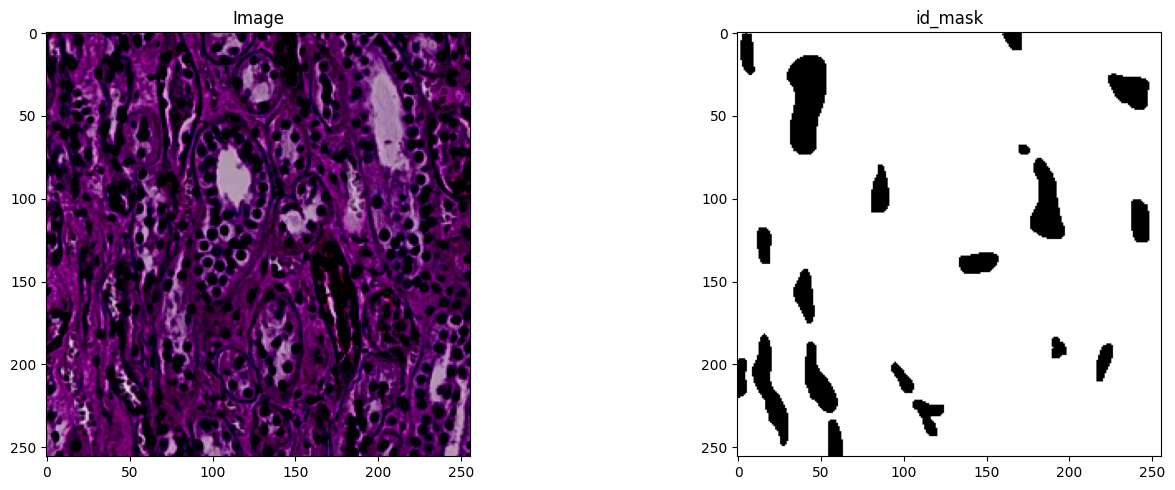

In [9]:
val.plot_example(10)

In [11]:
batch_size = 2
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [12]:
from transformers import SegformerForSemanticSegmentation

/home/ziereis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b2", 
        num_labels=4,
    ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
num_epochs = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels[:,0,:,:].long().to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)
        running_loss += loss.item()

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / i)

     # Testing
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        labels = labels[:,0,:,:].long().to(device)
        inputs = inputs.to(device)
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss

        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)

        running_loss += loss.item()
    
    test_accuracy.append(100 * correct / total)
    test_loss.append(running_loss / i)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Train Acc: {train_accuracy[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_accuracy[-1]}")


Epoch 1, Train Loss: 0.34778243857222835, Train Acc: 90.84508251793817, Test Loss: 0.2593276254401719, Test Acc: 92.06354735327548
Epoch 2, Train Loss: 0.26463330129855406, Train Acc: 92.17624010891937, Test Loss: 0.1737358592573769, Test Acc: 94.91971750728419
